In [9]:
from dataclasses import dataclass

import geometry
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]

In [11]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

In [12]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

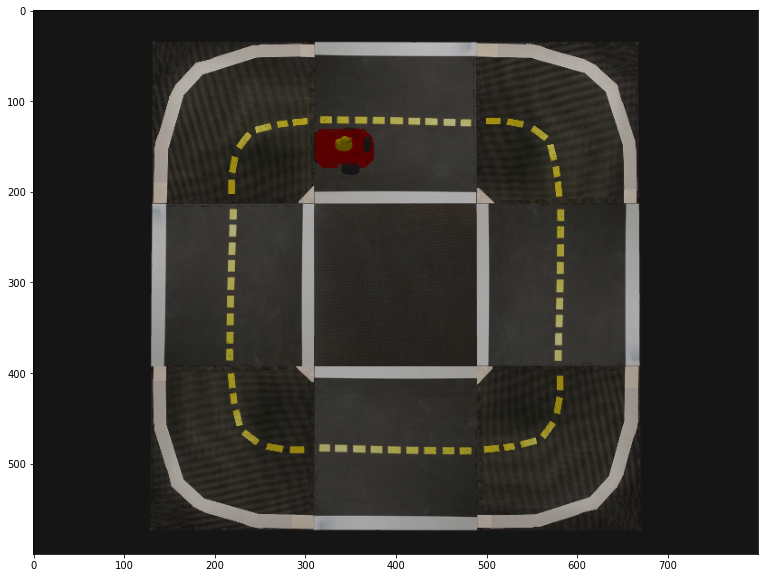

In [13]:
env.reset()
top_view = np.flip(env.render(mode="top_down"), [0])
plt.imshow(top_view)

In [14]:
import cv2

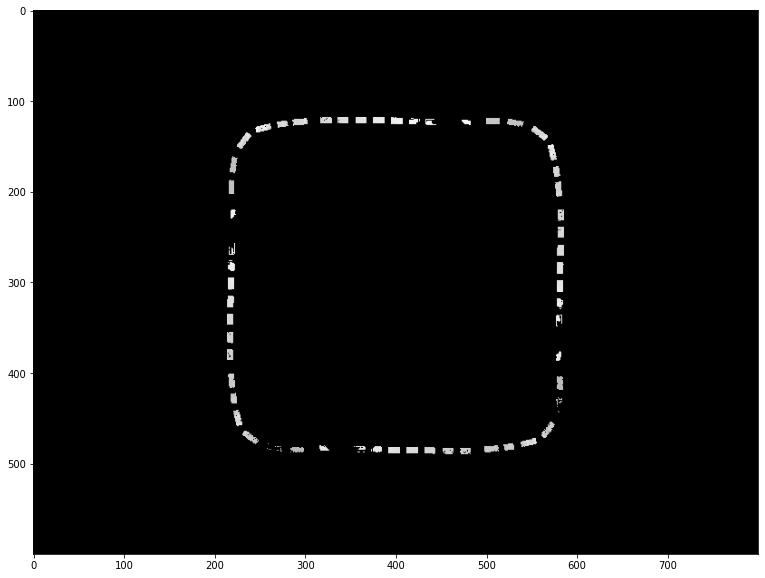

In [15]:
img_hsv = cv2.cvtColor(top_view, cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(top_view, cv2.COLOR_RGB2GRAY)

lower_yellow = np.array([20,100,150])
upper_yellow = np.array([30,255,255])

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask = cv2.bitwise_and(gray, mask_yellow)

plt.imshow(mask, cmap='gray')

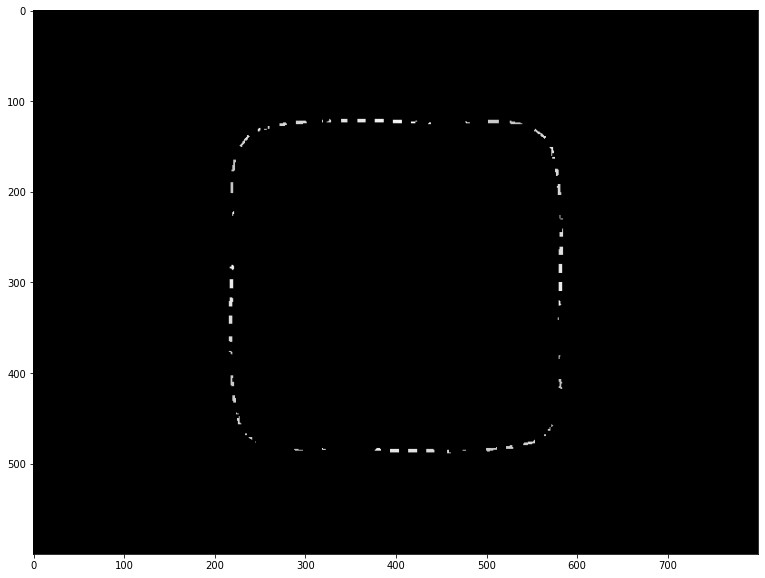

In [17]:
kernel = np.ones((4, 4), np.uint8)
eroded = cv2.erode(mask, kernel) 
plt.imshow(eroded, cmap='gray')

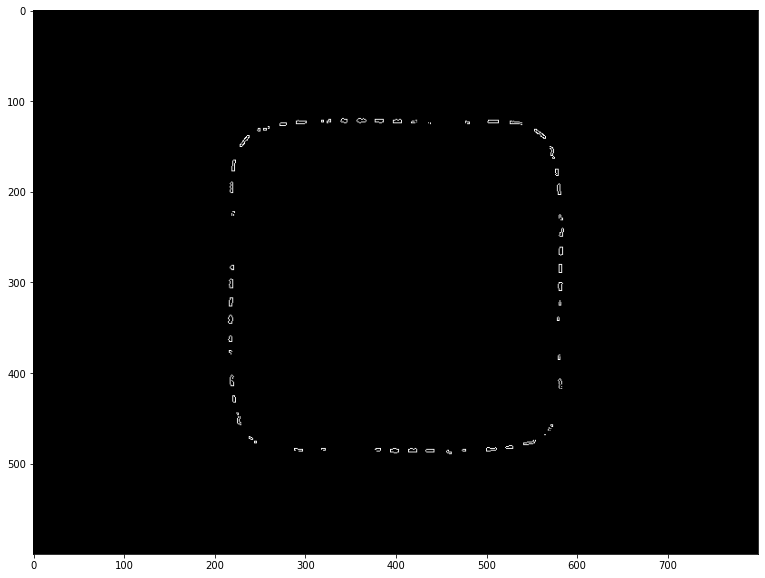

In [18]:
low_threshold = 89
high_threshold = 80
edges = cv2.Canny(eroded, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

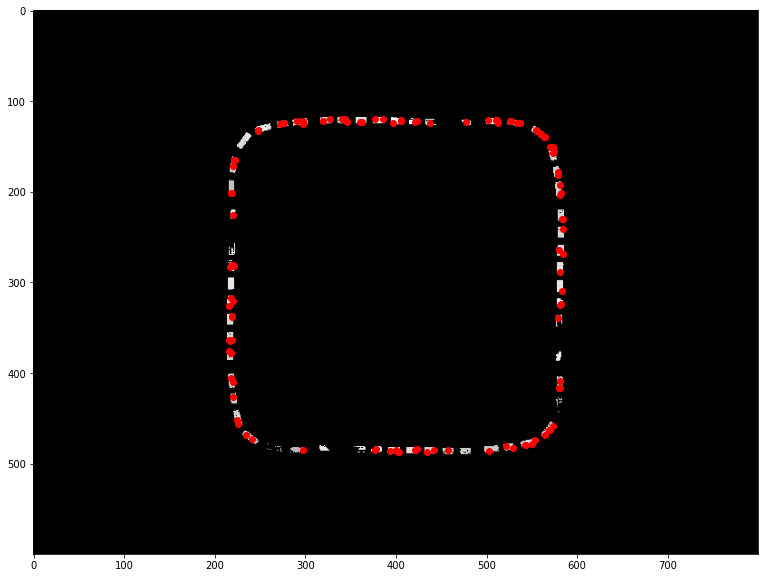

In [24]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(eroded, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)


points = lines.reshape(-1, 2)
plt.scatter(points[:, 0], points[:, 1], zorder=1, color="r")

plt.imshow(mask, zorder=0, cmap='gray')